# Model Explainability
Since we have a mapping from features to 1 or more substructures, we can see which parts of a reaction influence a model.

In [18]:
# Make sure shap is installed on binder
!pip install shap
import pickle
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem.AllChem import MolFromSmiles, MolFromSmarts
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import shap

IPythonConsole.molSize = (300, 300)

shap.initjs()

Let's load a model, the drfp fingerprints, as well as the mapping of a set of Buchwald-Hartwig reactions... 

In [25]:
X, y = pickle.load(open("buchwald_hartwig.pkl", "rb"))
mapping = pickle.load(open("buchwald_hartwig.map.pkl", "rb"))
model = pickle.load(open("buchwald_hartwig_model.pkl", "rb"))
print(len(X))
print(model)
print(y[0])

3955
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=12,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=999999, n_jobs=8, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)
70.41045785


Now use shap to try and explain this XGBRegressor model. Let's only use a subset of the data to speed it up.

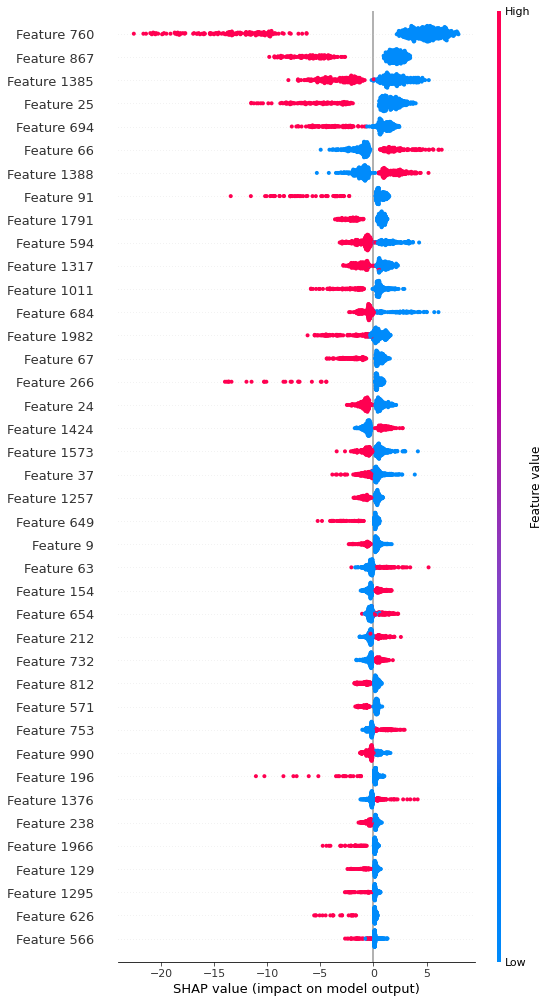

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:500])
shap.summary_plot(shap_values, X[:500], max_display=40)
pickle.dump((shap_values, X[:500]), open("shap_values.pkl", "wb"))

We now have a list of top features and their influence on the model output. The presence of feature 66 seems to have a positive influence on the model output, let's the associated molecular n-gram(s).

[CH2]1[CH2][N]=[CH][N]([CH3])[CH2]1
[CH2]1[CH2][CH2][CH2][CH2][CH2]1


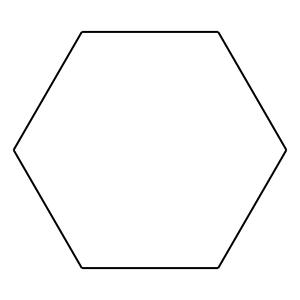

In [4]:
sub = list(mapping.get(66))[0]
print(sub)
MolFromSmiles(sub)

sub = list(mapping.get(24))[0]
print(sub)
MolFromSmiles(sub)

sub = list(mapping.get(1388))[0]
print(sub)
MolFromSmiles(sub)

For Feature 760, it's the other way around, it's absence has a positive effect on the model output. 
(Since the substructure was part of an aromatic system, we have to cheat a little bit to display it with rdkit.)

[C]([CH2])([CH2])[Cl]


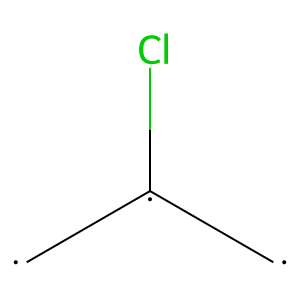

In [5]:
sub = list(mapping.get(760))[0].replace("c", "C")
print(sub)
MolFromSmiles(sub)

Now let's check out a single reaction and what features influence the prediction of its yield.

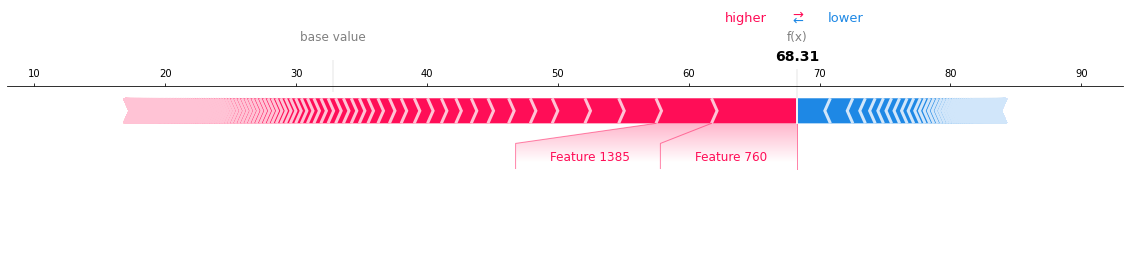

In [16]:
shap.force_plot(explainer.expected_value, shap_values[0, :], matplotlib=True)

In [24]:
for i in [1385, 760, 66, 24]:
    sub = list(mapping.get(i))[0]
    print(i, X[0][i], sub)

1385 [n]([cH][cH2])[o][cH2]
760 [c]([cH2])([cH2])[Cl]
66 [CH2]1[CH2][N]=[CH][N]([CH3])[CH2]1
24 [CH2]1[CH2][CH2][CH2][CH2][CH2]1


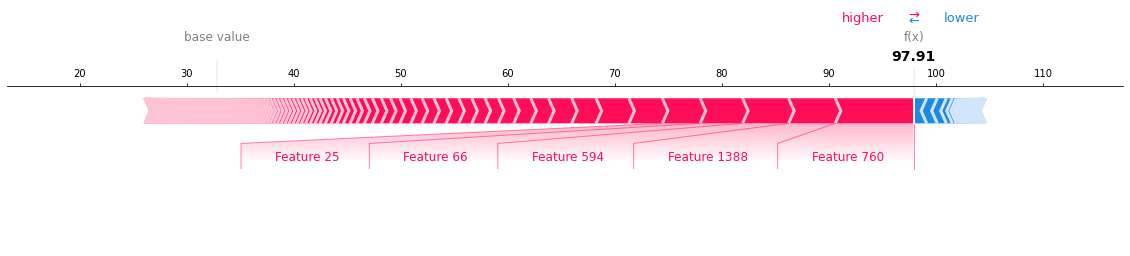

In [7]:
shap.force_plot(explainer.expected_value, shap_values[42, :], matplotlib=True)

These are just a few examples how the mapping can be used to analyse and interpret the output of a model, in this case a gradient boosting based one.